In [3]:
import pandas as pd 
import numpy as np
from xgboost import XGBRegressor

In [19]:
# read the data 
df = pd.read_csv('Health_lifting.csv')
df.head() # display the first few rows of the dataframe
df.columns # display the column names to be used later 

Index(['start_time', 'exercise_title', 'total_volume', 'max_weight',
       'top_set_reps', 'total_reps', 'workout_date', 'sleep_date', 'sleep_eff',
       'sleep_dur', 'awake_min', 'light_min', 'deep_min', 'rem_min',
       'phys_date', 'recovery', 'rhr', 'hrv', 'rr', 'spo2', 'skin_temp',
       'day_strain', 'sleep_need', 'sleep_debt', 'sleep_consistency',
       'sleep_performance', 'in_bed'],
      dtype='str')

In [44]:
# filter for one exercise 
bench = df[df["exercise_title"] == "Bench Press (Barbell)"].copy()

# create lagging features, want to use the previous weeks to predict the next week 
# previous max
bench["prev_max"] = bench["max_weight"].shift(1)

# rolling workload
bench["volume_3"] = bench["total_volume"].rolling(3, min_periods=1).mean()
bench["volume_7"] = bench["total_volume"].rolling(7, min_periods=1).mean()
bench["volume_14"] = bench["total_volume"].rolling(14, min_periods=1).mean()

# rolling recovery
bench["recovery_3"] = bench["recovery"].rolling(3, min_periods=1).mean()
bench["recovery_7"] = bench["recovery"].rolling(7, min_periods=1).mean()

# days since last session
bench["workout_date"] = pd.to_datetime(bench["workout_date"], errors="coerce") # ensure datetime format is correct
bench = bench.sort_values("workout_date").reset_index(drop=True) # sort by date


bench["days_since"] = bench["workout_date"].diff().dt.days.fillna(0).astype(int) # calculate days since last session, store as integer


# check if the last session was a personal record
# this conditonal probability is used to improve model performance by adding context,reduces randomness, stabilizes predictions, 
# improves short-term forecasting, gives trees discrete structure
bench["delta"] = bench["max_weight"] - bench["prev_max"] # calculate the change in max weight
bench["is_pr"] = (bench["delta"] > 0).astype(int) # flag if the current session is a personal record
bench["last_was_pr"] = bench["is_pr"].shift(1) # flag if the last session was a personal record 
bench["last_pr_delta"] = bench["delta"].shift(1) # store the delta from the last session

bench["last_was_pr"] = bench["last_was_pr"].fillna(0).astype(int) # fill NaN values and convert to integer
bench["last_pr_delta"] = bench["last_pr_delta"].fillna(0) # fill NaN values

bench = bench.dropna().reset_index(drop=True)


bench.head()

   max_weight  prev_max  delta  last_was_pr  last_pr_delta
0       205.0     225.0  -20.0            0            0.0
1       195.0     205.0  -10.0            0          -20.0
2       225.0     225.0    0.0            1           30.0
3       205.0     225.0  -20.0            0            0.0
4       235.0     205.0   30.0            0          -20.0
5       195.0     235.0  -40.0            1           30.0
6       225.0     195.0   30.0            0          -40.0
7       225.0     225.0    0.0            1           30.0
8       225.0     225.0    0.0            0            0.0
9       215.0     225.0  -10.0            0            0.0


,start_time,exercise_title,total_volume,max_weight,top_set_reps,total_reps,workout_date,sleep_date,sleep_eff,sleep_dur,...,volume_3,volume_7,volume_14,recovery_3,recovery_7,days_since,delta,is_pr,last_was_pr,last_pr_delta
0,2024-03-07 12:30:00,Bench Press (Barbell),4895.0,205.0,6,31,2024-03-07,2024-03-06,89.0,476.0,...,4720.000000,4720.000000,4720.000000,78.500000,78.500000,2,-20.0,0,0,0.0
1,2024-03-09 12:52:00,Bench Press (Barbell),3030.0,195.0,6,22,2024-03-09,2024-03-08,89.0,457.0,...,4156.666667,4156.666667,4156.666667,52.666667,52.666667,2,-10.0,0,0,-20.0
2,2024-03-15 15:42:00,Bench Press (Barbell),5100.0,225.0,7,32,2024-03-15,2024-03-14,91.0,493.0,...,4423.333333,4542.000000,4542.000000,44.666667,58.200000,3,0.0,0,1,30.0
3,2024-03-18 11:36:00,Bench Press (Barbell),5675.0,205.0,7,35,2024-03-18,2024-03-17,90.0,490.0,...,5305.000000,4730.833333,4730.833333,68.000000,60.333333,3,-20.0,0,0,0.0
4,2024-03-21 16:02:00,Bench Press (Barbell),4670.0,235.0,8,32,2024-03-21,2024-03-20,87.0,333.0,...,5148.333333,4722.142857,4722.142857,66.666667,61.857143,3,30.0,1,0,-20.0


In [46]:
# target and features
# target max weight next session
bench["delta"] = bench["max_weight"] - bench["prev_max"] # calculate the change in max weight

target = "delta"

# using the rolling features created above
features = [
    "prev_max",
    "total_volume",
    "volume_3",
    "volume_7",
    "volume_14",
    "recovery",
    "recovery_3",
    "recovery_7",
    "days_since",
    "last_was_pr",
    "last_pr_delta"
]

# prepare X and y
X = bench[features]
y = bench[target]

# spilt the data into train and test sets (80-20 split)
split = int(len(bench) * 0.8)

# time-based split because this is time series data
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]



In [47]:
# initialize and train the model using XGBoost Regressor
model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [48]:
# evaluating the mode 
pred = model.predict(X_test) # make predictions

pred_delta = model.predict(X_test) # predicted change in max weight

pred_abs = X_test["prev_max"] + pred_delta # predicted absolute max weight

mae = np.mean(np.abs(pred_abs - y_test - X_test["prev_max"])) # mean absolute error, comparing predicted max weight to actual max weight
baseline = np.mean(np.abs(y_test)) # baseline MAE (predicting no change), comparing actual max weight change to zero

# viewing results
print("Model MAE:", mae) 
print("Baseline MAE:", baseline)
print("Improvement:", baseline - mae)

Model MAE: 13.743019208312035
Baseline MAE: 14.545454545454545
Improvement: 0.8024353371425104


In [56]:
# predict the next x bench sessions 

future = bench.iloc[-1:].copy()   # start from last session
future_predictions = []           # store predicted maxes

for i in range(12):
    # prepare 1-row feature frame
    X_future = future[features]

    # predict delta
    delta_pred = model.predict(X_future)[0]

    # compute new max
    next_max = future["prev_max"].values[0] + delta_pred

    # store prediction (append to the LIST, not the dataframe)
    future_predictions.append(next_max)

    # roll state forward
    new_row = future.copy()

    # update state variables
    new_row["prev_max"] = next_max # update previous max to the newly predicted max
    new_row["max_weight"] = next_max # update current max weight to the newly predicted max
    new_row["delta"] = delta_pred # update delta to the predicted delta

    # PR logic
    new_row["is_pr"] = int(delta_pred > 0) # determine if the new session is a personal record
    new_row["last_was_pr"] = new_row["is_pr"] # update last_was_pr to current is_pr
    new_row["last_pr_delta"] = delta_pred # update last_pr_delta to current delta_pred 

    # assumptions for next session
    new_row["days_since"] = 7

    # keep workload/recovery constant (you can change this later)
    for col in ["total_volume", "volume_3", "volume_7", "volume_14",
                "recovery", "recovery_3", "recovery_7"]:
        new_row[col] = future[col].values[0]

    future = new_row

# print results
for i, w in enumerate(future_predictions, 1):
    print(f"Week {i}: {round(w,1)} lb")


Week 1: 228.2 lb
Week 2: 225.4 lb
Week 3: 221.0 lb
Week 4: 228.7 lb
Week 5: 212.6 lb
Week 6: 238.5 lb
Week 7: 210.4 lb
Week 8: 243.4 lb
Week 9: 215.2 lb
Week 10: 231.7 lb
Week 11: 215.5 lb
Week 12: 224.9 lb


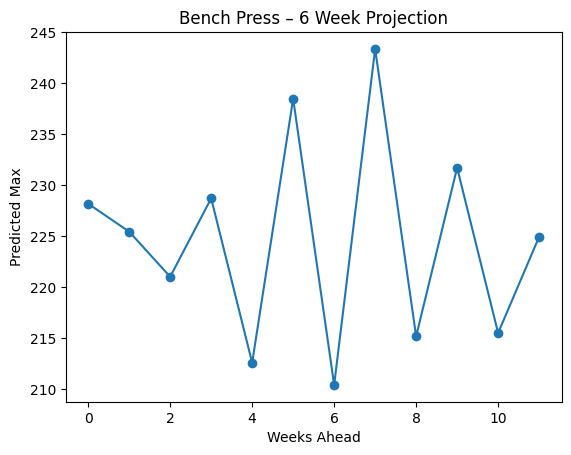

In [57]:
# graphing the results
from matplotlib import pyplot as plt

plt.plot(future_predictions, marker="o")
plt.title("Bench Press – 6 Week Projection")
plt.ylabel("Predicted Max")
plt.xlabel("Weeks Ahead")
plt.show()